In [11]:
import numpy as np
from lattice_class import *
import scipy.linalg
import matplotlib.pyplot as plt

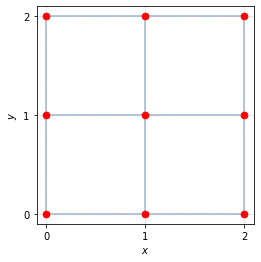

In [12]:
N = 3
lattice = SquareLattice(N, "open")

lattice.plot()
num_sites = lattice.get_num_sites()

lattice_sites = lattice.get_sites()
lattice_edges = lattice.get_edges()
reciprocal_lattice_sites = lattice.get_reciprocal_sites()

[[ 5.00000000e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  8.32667268e-17+9.71445147e-17j]
 [ 0.00000000e+00+0.00000000e+00j  5.00000000e-01+0.00000000e+00j
   8.32667268e-17+9.71445147e-17j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  8.32667268e-17-9.71445147e-17j
  -5.00000000e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 8.32667268e-17-9.71445147e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -5.00000000e-01+0.00000000e+00j]]
[array([[-0.5 -8.32667268e-17j,  0.  +0.00000000e+00j,
         0.  +0.00000000e+00j, -0.25+5.55111512e-17j],
       [ 0.  +0.00000000e+00j, -0.5 -8.32667268e-17j,
        -0.25+5.55111512e-17j,  0.  +0.00000000e+00j],
       [ 0.  +0.00000000e+00j,  0.25-5.55111512e-17j,
         0.5 +8.32667268e-17j,  0.  +0.00000000e+00j],
       [ 0.25-5.55111512e-17j,  0.  +0.00000000e+00j,
         0.  +0.00000000e+00j,  0.5 +8.32667268e-17j]]), array([[-5.00000000e-01+6.40

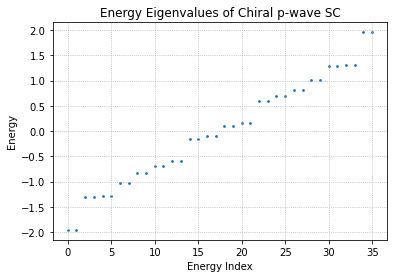

In [13]:
mu = -0.5
delta = complex(0.5, 0.0)

H_k = lambda k: np.array(
    [
        [-(np.cos(k[0]) + np.cos(k[1])) - mu, 0.0],
        [0.0, -(np.cos(k[0]) + np.cos(k[1])) - mu],
    ],
    dtype=complex,
)
gap_fct = lambda k: np.array(
    [
        [0.0, delta * complex(np.sin(k[0]), np.sin(k[1]))],
        [delta * complex(np.sin(k[0]), np.sin(k[1])), 0.0],
    ],
    dtype=complex,
)
H_BdG = lambda k: np.block(
    [[H_k(k), gap_fct(k)], [gap_fct(k).conj().T, -H_k(-k).conj()]]
)
dim_H_BdG = 4


def get_H_tilde(direction, axis=0):
    H_tilde = np.zeros(shape=(dim_H_BdG, dim_H_BdG), dtype=complex)
    for k in reciprocal_lattice_sites:
        H_tilde += (
            1.0
            / num_sites
            * H_BdG(np.array(k) / N)
            * np.exp(-direction * complex(0.0, 1.0) * k[axis] / N)
        )
    return H_tilde


H_direct_lattice = np.zeros(
    shape=(num_sites * dim_H_BdG, num_sites * dim_H_BdG), dtype=complex
)
block_indices = [
    slice(block_idx * dim_H_BdG, (block_idx + 1) * dim_H_BdG)
    for block_idx in range(lattice.get_num_sites())
]

H_Ce_tilde = get_H_tilde(0)
H_Le_tilde = get_H_tilde(-1, 0)
H_Ri_tilde = get_H_tilde(+1, 0)
H_To_tilde = get_H_tilde(-1, 1)
H_Lo_tilde = get_H_tilde(+1, 1)
H_tilde = [H_To_tilde, H_Ri_tilde, H_Lo_tilde, H_Le_tilde]

print(H_Ce_tilde)
print(H_tilde)

local_edge_indices = lattice.get_local_edge_indices()

for (site_idx, site) in enumerate(lattice.get_sites()):
    H_direct_lattice[block_indices[site_idx], block_indices[site_idx]] = H_Ce_tilde

    for neighbour_idx in lattice_edges[site_idx]:
        H_direct_lattice[
            block_indices[site_idx], block_indices[neighbour_idx]
        ] = H_tilde[lattice.get_local_edge_index(site_idx, neighbour_idx)]

energies, states = scipy.linalg.eigh(H_direct_lattice)
print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)

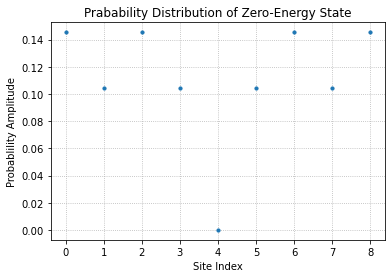

In [14]:
gs_wave_function = states[:, gs_idx]
gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
gs_probabilities = np.zeros(shape=(num_sites, 1))

for site_idx in range(num_sites):
    gs_probabilities[site_idx] = np.sum(gs_probabilities_nambu[block_indices[site_idx]])

plt.xlabel("Site Index")
plt.xticks(range(0, num_sites, num_sites // min(num_sites, 20)))
plt.ylabel("Probablility Amplitude")
plt.title("Prabability Distribution of Zero-Energy State")
plt.grid(linestyle=":", zorder=-10)
plt.scatter(range(num_sites), gs_probabilities, s=10, zorder=10)

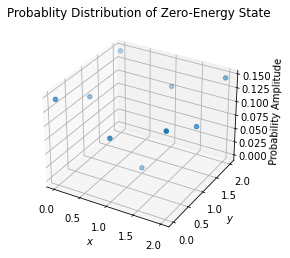

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
x_values = [k[0] for k in lattice_sites]
y_values = [k[1] for k in lattice_sites]

plt.grid(linestyle=":")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel("Probability Amplitude")
ax.set_title("Probablity Distribution of Zero-Energy State")
ax.scatter(x_values, y_values, gs_probabilities)